# We can look at the trajectories of both the weights and activity in phase space

In [1]:
import numpy as np
import numpy.lib.stride_tricks
import matplotlib.pyplot as plt
import scipy.linalg
import matplotlib.scale
plt.style.use('seaborn')
plt.rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Sans serif']})
plt.rc('text', usetex=True)
np.random.seed(7) # seed so plots are repeatable

def roll_matrix_rows(matrix, roll_amounts):
	'''roll each row of a 2D matrix by an independent amount, as specified in `roll_amounts`.'''
	matrix_rolled = matrix[:, [*range(matrix.shape[1]),*range(matrix.shape[1]-1)]].copy()
	stride_0, stride_1 = matrix_rolled.strides
	num_cols = matrix.shape[1]
	result = numpy.lib.stride_tricks.as_strided(matrix_rolled, (*matrix.shape, num_cols), (stride_0 ,stride_1, stride_1))
	return result[np.arange(matrix.shape[0]), (num_cols-roll_amounts) % num_cols]

In [2]:
N = 32
neuron_indices = np.arange(N)

profile_to_matrix = lambda profile: scipy.linalg.circulant(profile)
get_cosine_from_fourier_modes = lambda fourier_modes: np.fft.ifft(np.hstack((fourier_modes, np.flip(fourier_modes[1:-1])))).real

v_magnitude = .25
a = v_magnitude * (1 + np.cos(2*np.pi*neuron_indices/N)) # a = ||v|| * F^-1{[1,1/2,0,...]}
# want a * a - gamma \propto F^-1{[1,1,0,...]}.
# Here, a * a = ||v||^2 * F^-1{[1,1/4,0,...]}, so if gamma = 3/4||v||^2 then we get
# a * a - gamma = ||v||^2 * F^-1{[1/4,1/4,0,...]}, and the lambda scaling can take us back to [1,1,0,...]
gamma = 3 / 4 * v_magnitude**2
W = profile_to_matrix(get_cosine_from_fourier_modes([1,1] + [0]*(N//2+1-2)))
_lambda = 1/4*N*v_magnitude**2

input = profile_to_matrix(a)

In [3]:
def simulate_fixed_activity(a, eta=0.001, _lambda=5.0):
	N = a.shape[1]
	W = np.zeros((N,N))

	delta_W_trace = []
	W_trace = []

	for t in range(a.shape[0]):
		delta_W = a[t,:].reshape(N,1) @ a[t,:].reshape(1,N) - _lambda*W - gamma
		W += eta*delta_W
		delta_W_trace.append(delta_W.copy())
		W_trace.append(W.copy())

	return W_trace, delta_W_trace

def simulate_fixed_weights(W, eta=0.001, _lambda=5.0, periods=1000):
	N = W.shape[0]
	a = np.zeros(N)

	delta_a_trace = []
	a_trace = []

	for t in range(N*periods):
		delta_a = -a + W@a
		a += eta*delta_a
		delta_a_trace.append(delta_a.copy())
		a_trace.append(a.copy())

	return a_trace, delta_a_trace

def get_circulant_matrix_profile(matrix):
	N = np.arange(matrix.shape[0])
	unrolled_matrix = roll_matrix_rows(matrix, -N)

	mu = unrolled_matrix.mean(axis=0)
	stddev = np.sqrt(unrolled_matrix.var(axis=0))

	return mu, stddev

def plot_circulant_matrix_as_profile(matrix, plot_stddev=True, roll=False, show=True):
	N = np.arange(matrix.shape[0])
	mu, stddev = get_circulant_matrix_profile(matrix)
	if roll:
		N -= matrix.shape[0]//2
		mu = np.roll(mu, matrix.shape[0]//2)
		stddev = np.roll(stddev, matrix.shape[0]//2)

	plt.plot(N, mu)
	if plot_stddev:
		plt.fill_between(N, mu-stddev, mu+stddev, alpha=0.2)
	if show:
		plt.show()

## functions for generating phase portrait
def profile_to_mu_amp_phase(profile):
	return profile.mean(), (profile.max()-profile.min())/2, np.argmax(profile)

def grad_W_over_period(W, a, _lambda):
	grad_W = np.zeros_like(W)
	for t in range(a.shape[0]):
		grad_W += a[t,:].reshape(N,1) @ a[t,:].reshape(1,N) - _lambda*W - gamma
	return grad_W

def get_grad_W_over_period(mu, amp, eta=0.001, _lambda=5.0):
	W = profile_to_matrix(mu + amp*np.cos(2*np.pi*neuron_indices/N))
	mu_before, amp_before, phase_before = profile_to_mu_amp_phase(get_circulant_matrix_profile(W)[0])
	mu_after, amp_after, phase_after = profile_to_mu_amp_phase(get_circulant_matrix_profile(W+eta*grad_W_over_period(W, input, _lambda))[0])
	return (mu_after-mu_before, amp_after-amp_before, phase_after-phase_before)

def get_grad_a(mu, amp, eta=0.001):
	a = profile_to_matrix(mu + amp*np.cos(2*np.pi*neuron_indices/N))
	mu_before, amp_before, phase_before = profile_to_mu_amp_phase(get_circulant_matrix_profile(a)[0])
	mu_after, amp_after, phase_after = profile_to_mu_amp_phase(get_circulant_matrix_profile(a+eta*(-a + W@a))[0])
	return (mu_after-mu_before, amp_after-amp_before, phase_after-phase_before)

## Trajectory of the activity

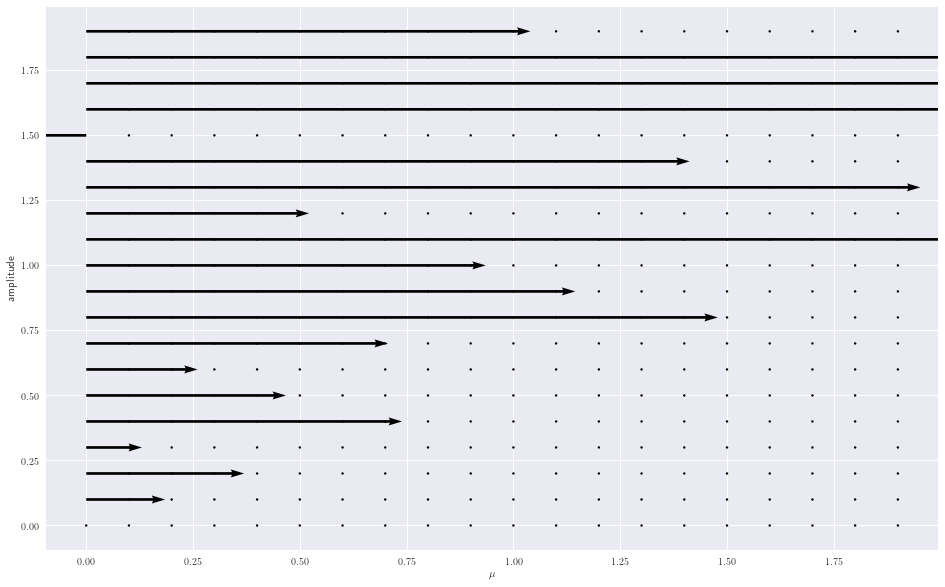

In [4]:
mu_range = np.arange(0.0,2,.1)
amp_range = np.arange(0.0,2,.1)
mu_grid, amp_grid = np.meshgrid(mu_range, amp_range)

mu_grad = np.zeros((len(mu_range), len(amp_range)))
amp_grad = np.zeros((len(mu_range), len(amp_range)))
phase_grad = np.zeros((len(mu_range), len(amp_range)))

for i,mu in enumerate(mu_range):
	for j,amp in enumerate(amp_range):
		mu_amp_phase = get_grad_a(mu, amp)
		mu_grad[i,j] = mu_amp_phase[0]
		amp_grad[i,j] = mu_amp_phase[1]
		phase_grad[i,j] = mu_amp_phase[2]

plt.figure(figsize=(16,10))
plt.quiver(mu_grid, amp_grid, mu_grad.T, amp_grad.T)
plt.xlabel('$\\mu$')
plt.ylabel('amplitude')
plt.show()

## Trajectory of the weights

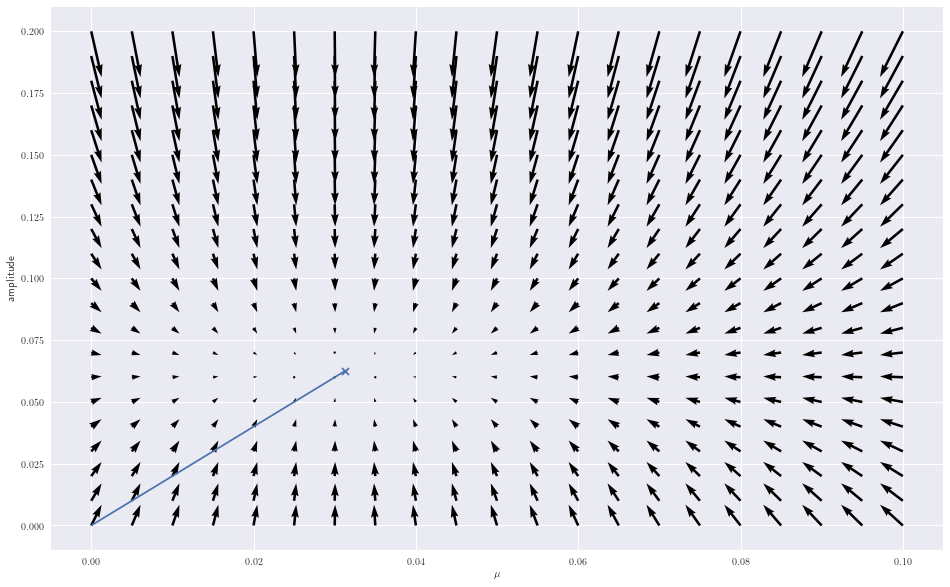

In [5]:
mu_range = np.arange(0.0,0.105,.005)
amp_range = np.arange(0.0,0.21,.01)
mu_grid, amp_grid = np.meshgrid(mu_range, amp_range)

mu_grad = np.zeros((len(mu_range), len(amp_range)))
amp_grad = np.zeros((len(mu_range), len(amp_range)))
phase_grad = np.zeros((len(mu_range), len(amp_range)))

for i,mu in enumerate(mu_range):
	for j,amp in enumerate(amp_range):
		mu_amp_phase = get_grad_W_over_period(mu, amp, _lambda=_lambda)
		mu_grad[i,j] = mu_amp_phase[0]
		amp_grad[i,j] = mu_amp_phase[1]
		phase_grad[i,j] = mu_amp_phase[2]

W_trace, delta_W_trace = simulate_fixed_activity(np.tile(input, (1000,1)), eta=0.001, _lambda=_lambda)
mus, amps = np.array([profile_to_mu_amp_phase(get_circulant_matrix_profile(W)[0])[:2] for W in W_trace[::100]]).T

plt.figure(figsize=(16,10))
plt.quiver(mu_grid, amp_grid, mu_grad.T, amp_grad.T)
plt.scatter(*profile_to_mu_amp_phase(get_circulant_matrix_profile(W)[0])[:2], marker='x', label='stable weights')
plt.plot(mus, amps)
plt.xlabel('$\\mu$')
plt.ylabel('amplitude')
plt.show()